In [1]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="rdbench"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    # for ext in ('png',):
    #     fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    pass 


In [2]:
re_hook_pmembb = re.compile(r"hook:pmembb:rpmbb_store_(create|free|save|load) ([0-9]+\.[0-9]+)")
def df_extract_hook_pmembb_time(stderr_path: Path):
    text = stderr_path.read_text()
    matches = re_hook_pmembb.findall(text)
    return pd.DataFrame(matches, columns=["type", "time"])

def extract_hook_pmembb_time_max(stderr_path: Path):
    return (
        df_extract_hook_pmembb_time(stderr_path)
        .groupby("type")
        .max()
        .transpose()
        .rename(columns={
            "create": "createTime",
            "free": "freeTime",
            "save": "saveTime",
            "load": "loadTime",
        })
        .reset_index(drop=True)
        .astype(float)
        .loc[0,:]
        .to_dict()
    )

wpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
rpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
extract_hook_pmembb_time_max(rpath)


{'createTime': 14.976, 'freeTime': 0.023, 'loadTime': 0.005}

In [4]:
RAW_BASEDIR=Path(f"../../raw/")

default_metadata={
}

job_group = (
    ("rdbench-pmembb/2024.01.29-15.40.22-nosync", {}),
)

def job_dirs(job_group_dir: str):
    dir = RAW_BASEDIR / job_group_dir
    return (f.resolve() for f in dir.iterdir() if f.is_dir())

re_timestamp = re.compile(r'([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})')
def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None

re_runid = re.compile(r"_([0-9]+)\.json")
def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None

def load_nodelist(job_dir: Path):
    with(job_dir / f"nodelist").open() as f:
        return list(map(lambda s: s.strip(), f.readlines()))

src = []
for job_group_dir,metadata in job_group:
    for job_dir in job_dirs(job_group_dir):
        try:
            job_start = {"job_start": parse_job_start_timestamp(job_dir)}
            job_nodelist = {"nodelist": load_nodelist(job_dir)}
        except Exception as e:
            print(f"{job_dir}, {e}")
        for job_params_file in job_dir.glob("job_params_*.json"):
            try:
                runid = get_runid(job_params_file)
                job_params = json.loads(job_params_file.read_text())
                rdbench_result_file = job_dir / f"rdbench_stdout_{runid}.json"
                rdbench_result = json.loads(rdbench_result_file.read_text())
                pmembb_time = extract_hook_pmembb_time_max(job_dir / f"rdbench_stderr_{runid}.txt")
                src.append({
                    **default_metadata,
                    **metadata,
                    **job_start,
                    **job_nodelist,
                    **job_params,
                    **pmembb_time,
                    **rdbench_result,
                    "runid": runid,
                })
            except FileNotFoundError as e:
                print(e)
            except Exception as e:
                print(f'{job_dir}/{job_params_file}, {e}')

# df_src = (
#     pd.DataFrame(src)
#     .assign(odirect=lambda x: x["Command line"].str.contains("--posix.odirect"))
#     .assign(strided=lambda x: x["summary_transferSize"] == x["summary_blockSize"])
#     .rename({
#         "summary_bwMaxMIB": "bw",
#         "summary_MeanTime": "time",
#         "summary_segmentCount": "segmentCount",
#         "summary_blockSize": "blockSize",
#         "summary_transferSize": "transferSize",
#         "summary_operation": "operation",
#         "Parameters_filePerProc": "fpp",
#         "Parameters_reorderTasks": "reorder",
#         "summary_API": "api",
#         "result_access": "access",
#         "result_bwMiB": "bwMiB",
#         "result_openTime": "openTime",
#         "result_wrRdTime": "wrRdTime",
#         "result_closeTime": "closeTime",
#         "result_totalTime": "totalTime",
#     }, axis=1)
#     .astype({"fpp": bool, "reorder": bool,})
#     .assign(bwGB=lambda x: x["bwMiB"] * 2**20 / 10**9)
# )
# df_src["label"] = np.select([
#     (df_src["access"] == "write"),
#     (df_src["access"] == "read") & (df_src["reorder"] == True),
#     (df_src["access"] == "read") & (df_src["reorder"] == False),
# ], ["Write", "Read (remote)", "Read (local)"])


df_src = (
    pd.DataFrame(src)
    .drop(columns=[
        'phaseDurationsSec',
    ])
    .assign(bwGB=lambda x: x['writeBandwidthByte'] / 1000**3)
)

df_src.head()


,job_start,nodelist,nnodes,ppn,np,jobid,runid,pmem_path,pmem_size,lustre_version,...,nfiles,fileSize,totalWriteSizeByte,calcTimeSec,commTimeSec,writeTimeSec,writeBandwidthByte,initialTimeSec,finalizeTimeSec,bwGB
0,2024.01.29-15.40.22,"[bnode030, bnode031, bnode032, bnode040]",4,48,192,168085.nqsv,0,/dev/dax0.0,0,2.12.9_ddn38,...,10,77309411328,773094113280,393.477076,21.063945,8.814004,8.771202e+10,29.708876,59.314632,87.712020
1,2024.01.29-15.40.22,"[bnode001, bnode002, bnode003, bnode004, bnode...",64,48,3072,168110.nqsv,0,/dev/dax0.0,0,2.12.9_ddn38,...,10,1236950581248,12369505812480,389.427047,52.800364,10.586331,1.168441e+12,36.153918,64.808835,1168.441238
2,2024.01.29-15.40.22,"[bnode001, bnode002, bnode003, bnode004, bnode...",49,48,2352,168107.nqsv,0,/dev/dax0.0,0,2.12.9_ddn38,...,10,947040288768,9470402887680,392.719142,36.629800,10.222118,9.264619e+11,34.049562,59.575162,926.461873
3,2024.01.29-15.40.22,"[bnode001, bnode002, bnode003, bnode004, bnode...",49,48,2352,168105.nqsv,0,/dev/dax0.0,0,2.12.9_ddn38,...,10,947040288768,9470402887680,391.887261,43.826520,10.988426,8.618526e+11,33.822253,62.021545,861.852578
4,2024.01.29-15.40.22,"[bnode022, bnode023, bnode024, bnode025, bnode...",36,48,1728,168101.nqsv,0,/dev/dax0.0,0,2.12.9_ddn38,...,10,695784701952,6957847019520,391.390656,33.630722,9.627710,7.226897e+11,33.067183,59.285396,722.689719


In [6]:
df = df_src

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# display(df.columns.to_list())

(
    df[[
        "spack_env_name",
        "nnodes",
        # "segmentCount",
        # "blockSize",
        "bwGB",
    ]]
    # .head()
)


,spack_env_name,nnodes,bwGB
0,mpiio-pmembb-deferred-open,4,87.712020
1,mpiio-pmembb,64,1168.441238
2,mpiio-pmembb-deferred-open,49,926.461873
3,mpiio-pmembb-deferred-open,49,861.852578
4,mpiio-pmembb-deferred-open,36,722.689719
5,mpiio-pmembb-deferred-open,36,706.817777
6,mpiio-pmembb-deferred-open,4,92.500124
7,mpiio-pmembb,36,731.825098
8,mpiio-pmembb,25,515.568929
9,mpiio-pmembb,4,87.633009


<Axes: xlabel='spack_env_name,nnodes,lustre_stripe_count'>

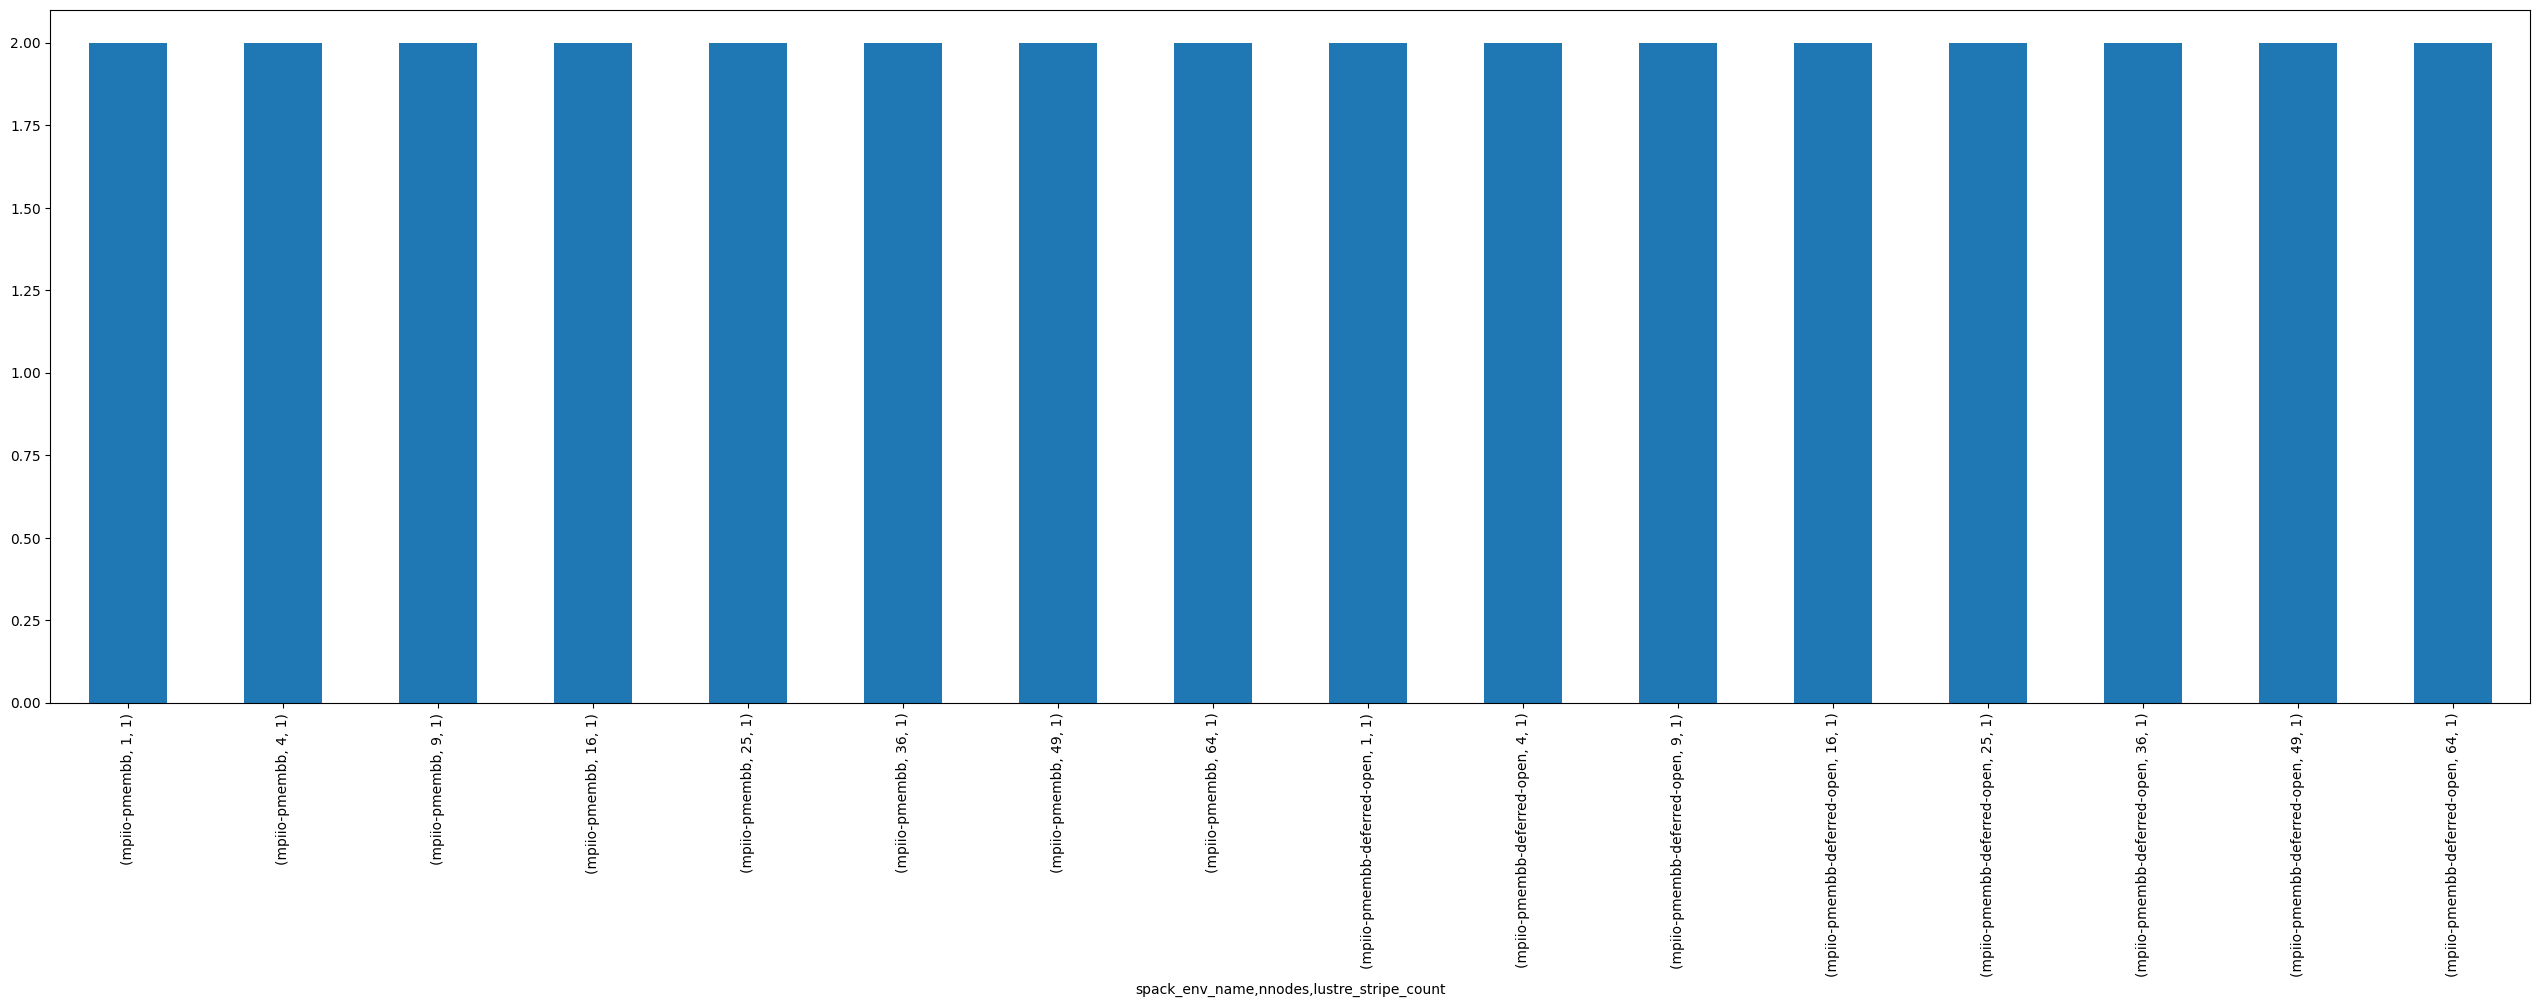

In [7]:
df = df_src
same_setting_columns = [
    "spack_env_name", "nnodes", "lustre_stripe_count"]
same_setting_grouper = df.groupby(same_setting_columns)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# display(same_setting_grouper.size())
(
    same_setting_grouper
    .size()
    .plot(figsize=(32, 9), kind="bar")
)


,spack_env_name,nnodes,lustre_stripe_count,bwGB
0,mpiio-pmembb,1,1,23.570439
1,mpiio-pmembb,4,1,87.715552
2,mpiio-pmembb,9,1,192.837172
3,mpiio-pmembb,16,1,337.448248
4,mpiio-pmembb,25,1,520.826046
5,mpiio-pmembb,36,1,736.188194
6,mpiio-pmembb,49,1,959.948339
7,mpiio-pmembb,64,1,1221.952894


,bwGB
spack_env_name,mpiio-pmembb
nnodes,
1,23.570439
4,87.715552
9,192.837172
16,337.448248
25,520.826046
36,736.188194
49,959.948339
64,1221.952894


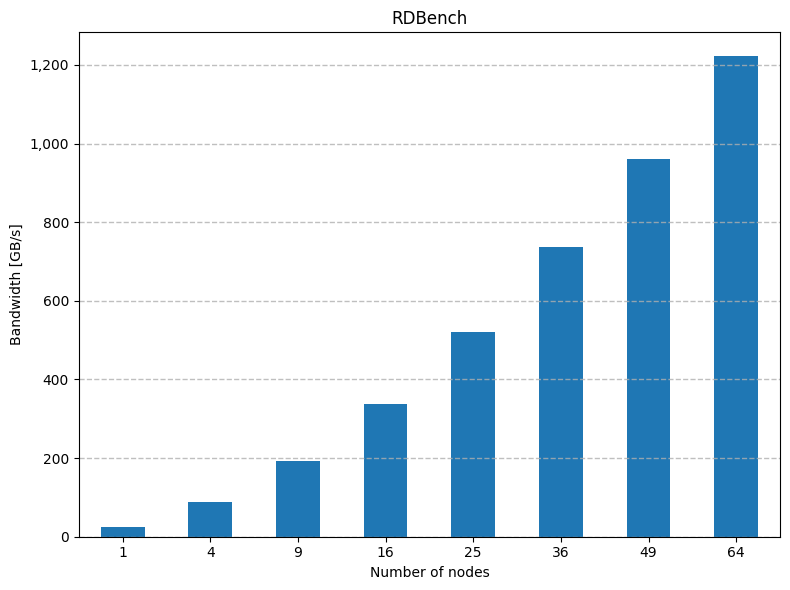

NameError: name 'access' is not defined

In [16]:
df = (
    same_setting_grouper["bwGB"].max()
    # .agg({
    #     "bw": "max",
    #     "time": "min",
    # })
    .reset_index()
    # .assign(bwGB=lambda x: x["bw"] * 2**20 / 10**9)
    .query("lustre_stripe_count == 1")
    .query("spack_env_name == 'mpiio-pmembb'")
)

display(df)

df_plot = df.pivot(index="nnodes", columns=["spack_env_name"], values=["bwGB"])

display(df_plot)


fig = plt.figure(figsize=(8, 6), dpi=100)
fig.patch.set_alpha(1)

ax = df_plot.plot(
    ax=fig.add_subplot(),
    kind="bar",
    # kind="line",
    # xlabel="Transfer size [B]",
    xlabel="Number of nodes",
    ylabel="Bandwidth [GB/s]",
    # style=".-",
    legend=False,
    rot=0,
)

ax.set_title(f"RDBench")
# ax.set_xscale("log", base=2)
# ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
# handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
# ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

# legend_title = ax.get_legend().get_title().get_text()
# ax.legend(title=legend_title, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
# ax.legend(title="Transfer size")
plt.tight_layout()

fig.show()
plt.show()
save(fig, F"ior_{access}_{'remote' if reorder else 'local'}_{value}")
